# Hypothesis

Resale Price is a linear combination of Resale Period, Distance Travelled, Latitude, Longitude and Number of Cylinders

# Usefulness

"What should be a good price which a seller can put for his car?"
If our hypothesis is accepted, we can use it to suggest prices to the car sellers on Craiglist. This can be also be useful for buyers where they can see "What is a reasonable buying price for a car with a given configuration, based on past data?"

# Work Summary

We have come with a linear regression model which uses 80% train data and 20% test data. The model has a mean absolute error of 12000 dollars using our own implementation and 5700 dollar using sklearn implementation. We understand that this difference is because of negative prices being predicted by linear regression.
We have cleaned the full dataset and played around with different categorical and numerical features. We have found these 5 features to be highly correlated to the price which sellers put up on Craiglist.


In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Read Data

In [2]:
def read_data():
    file = "./data/craigslistVehicles.csv"
    input_data = pd.read_csv(file, sep=",")
    return input_data

input_data = read_data()

# Data Cleaning

1. Get the percentage of nulls per column. This is to identify columns which can be used for our regression without significant reduction in the input data rows

In [3]:
numberOfDataPoints = input_data.shape[0];
nullCountPerColumn = input_data.isnull().sum()
percentageOfNull = (nullCountPerColumn/numberOfDataPoints) * 100
percentageOfNull.sort_values(ascending = False)

size            65.845692
VIN             64.538102
condition       41.307914
type            41.154922
cylinders       40.753336
paint_color     40.612736
drive           38.756912
odometer        33.130426
manufacturer     7.907502
make             4.056139
fuel             1.147516
transmission     1.051914
long             1.010162
lat              1.010162
title_status     0.668770
year             0.043965
image_url        0.008557
price            0.000000
city             0.000000
url              0.000000
dtype: float64

2. Columns with just 1 unique values should be removed. There is no such column in our data

In [4]:
input_data.nunique().sort_values()

transmission         3
drive                3
size                 4
fuel                 5
condition            6
title_status         6
cylinders            8
paint_color         12
type                13
manufacturer        42
year               117
city               481
price            20542
make             58093
odometer        112157
long            134845
lat             134951
VIN             152014
image_url       536370
url             677812
dtype: int64

3. This is to analyze if any of the numerical columns have very high values. 
Ex. As seen, price column has very high values which needs to be cleaned

In [5]:
input_data.describe()

,price,year,odometer,lat,long
count,6.778120e+05,677514.000000,4.532500e+05,670965.000000,670965.000000
mean,6.145579e+05,2005.014767,1.125260e+05,38.922054,-93.913802
std,4.469918e+07,12.037830,1.340298e+05,6.167192,17.237383
min,1.000000e+00,1900.000000,0.000000e+00,-84.810047,-179.824219
25%,3.500000e+03,2002.000000,5.600000e+04,34.956944,-106.221100
50%,7.500000e+03,2007.000000,1.052265e+05,39.499100,-88.328200
75%,1.550000e+04,2013.000000,1.510000e+05,42.659300,-81.037100
max,4.294967e+09,2019.000000,1.000000e+07,90.000000,127.790222


# Identifying Columns Of Interest And Cleaning Them
We tried a different subset of features, both categorical and numerical. 
We tried all the categorical features (Ex. transmission, type, etc) by using the following steps
1. We first cleaned the data by removing all rows where that categorical feature was null
2. we are not using One Hot Encoding as it has not been covered in the class

We found out that linear regression gave very high values when such categorical variables were used. This caused a lot of error in the validation results. Thus we have not included any such categorical variable in our model.
We identify only numerical columns as columns of interest and hence, need to clean them.

In [6]:
# Data Cleaning
sample_input = input_data
print(sample_input.shape)

def convertToInteger(x):
    arr = x.split(' ');
    cyl = int(arr[0])
    return cyl


sample_input = sample_input[pd.notnull(sample_input['cylinders'])]
print(sample_input.shape)

# Cleaning cyliners column as it contains null values
sample_input = sample_input[(sample_input['cylinders'] == "4 cylinders") | (sample_input['cylinders'] == "6 cylinders") | (sample_input['cylinders'] == "8 cylinders") | (sample_input['cylinders'] == "5 cylinders") | (sample_input['cylinders'] == "10 cylinders") | (sample_input['cylinders'] == "3 cylinders") | (sample_input['cylinders'] == "12 cylinders")]
# Getting integer from text values of cyliner column
sample_input['cylinders'] = sample_input['cylinders'].map(convertToInteger)
print(sample_input.shape)

# Clean null values in latitude and longitude
sample_input = sample_input[pd.notnull(sample_input['lat'])]
print(sample_input.shape)
sample_input = sample_input[pd.notnull(sample_input['long'])]
print(sample_input.shape)

sample_input = sample_input[sample_input["odometer"] > 0]
print(sample_input.shape)
sample_input = sample_input[sample_input["year"] > 2000]
print(sample_input.shape)

# We obsereved that many cars have very high prices of the order of 4.294967e+09. 
# These see to be outlier. Thus we picked the price range which is most relevant today
sample_input = sample_input[sample_input["price"] > 2000]
sample_input = sample_input[sample_input["price"] < 80000]
print(sample_input.shape)

# We use IQR analysis to find outliers in odometer column and remove them
quartile_1, quartile_3 = np.percentile(sample_input["odometer"], [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)

sample_input = sample_input[(sample_input['odometer'] > lower_bound) & (sample_input['odometer'] < upper_bound)]
print(sample_input.shape)

sample_input.head()

(677812, 20)
(401581, 20)
(387047, 20)
(385175, 20)
(385175, 20)
(302842, 20)
(256735, 20)
(238558, 20)
(236420, 20)


,url,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,lat,long
1,https://tricities.craigslist.org/cto/d/2008-bu...,tricities,5000,2008.0,buick,lucerne cxl v6,like new,6,gas,51000.0,clean,automatic,NaN,fwd,full-size,sedan,grey,https://images.craigslist.org/00N0N_1LSHqLESW9...,35.777999,-83.612533
2,https://tricities.craigslist.org/cto/d/2006-po...,tricities,13500,2006.0,NaN,Pont GTO,excellent,8,gas,93000.0,clean,automatic,NaN,rwd,mid-size,coupe,red,https://images.craigslist.org/00Y0Y_4cbEgS4prY...,36.333900,-82.340800
4,https://tricities.craigslist.org/cto/d/2016-fo...,tricities,37900,2016.0,ford,f350,excellent,8,diesel,70500.0,clean,automatic,NaN,4wd,NaN,truck,white,https://images.craigslist.org/00k0k_ls78o6lwVq...,36.272932,-82.537537
8,https://tricities.craigslist.org/ctd/d/2010-ni...,tricities,9950,2010.0,nissan,armada,excellent,8,gas,155244.0,clean,automatic,5N1AA0NC7AN602236,4wd,full-size,SUV,black,https://images.craigslist.org/00n0n_gOocwNdHG0...,37.286501,-80.056719
9,https://tricities.craigslist.org/ctd/d/2003-fo...,tricities,5950,2003.0,ford,expedition,excellent,8,gas,141602.0,clean,automatic,1FMFU18L73LC08586,4wd,full-size,SUV,green,https://images.craigslist.org/00V0V_darIoRE1z1...,37.286501,-80.056719


# Analysis

Reference - https://www.kaggle.com/austinreese/craigslist-carstrucks-data/kernels

These plots help us in understanding the different unique values and their frequency count for each column. Thus helping us in identifying outliers which can be cleaned.

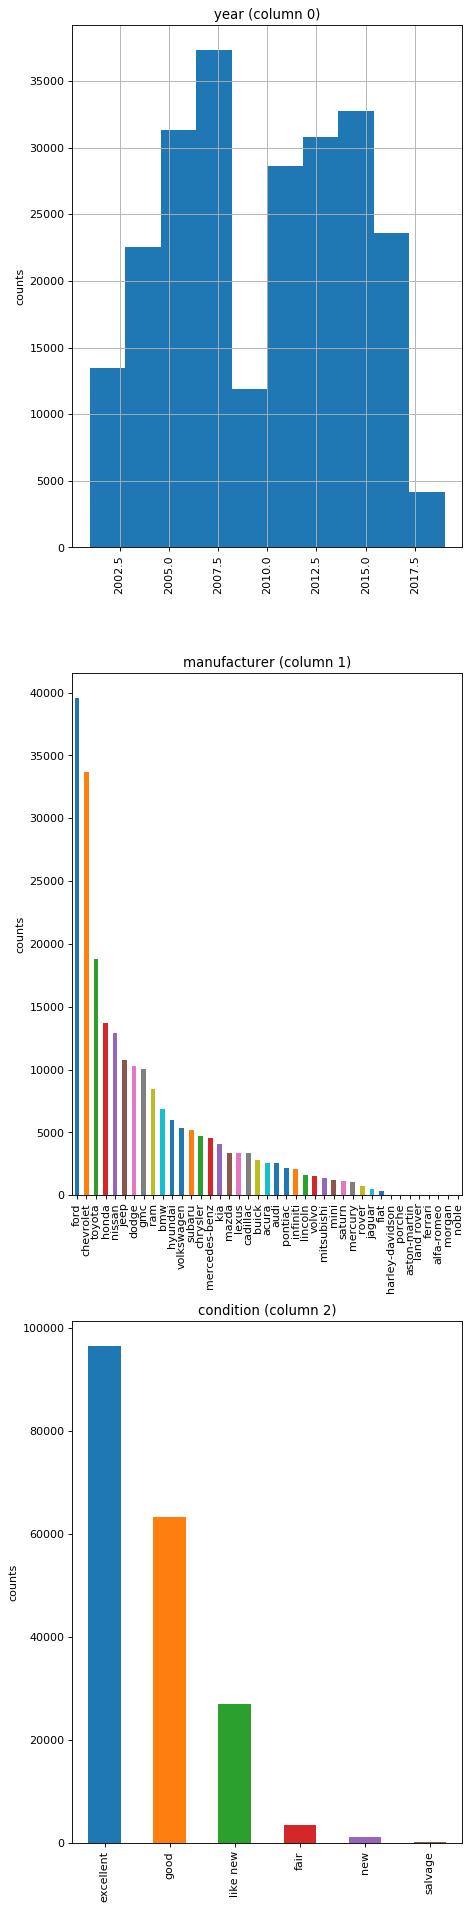

In [14]:
from mpl_toolkits.mplot3d import Axes3D
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
plotPerColumnDistribution(sample_input, 3, 1)

# Features

In [8]:
# Numerical Data
X = pd.DataFrame({})
X["resalePeriod"] = (2019 - sample_input["year"])
X["distanceTravelled"] = sample_input["odometer"]
X["latitude"] = sample_input["lat"]
X["longitude"] = sample_input["long"]
X["cylinders"] = sample_input["cylinders"]

Y = pd.DataFrame({})
Y["price"] = sample_input["price"]

X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)
X.head()

,resalePeriod,distanceTravelled,latitude,longitude,cylinders
0,11.0,51000.0,35.777999,-83.612533,6
1,13.0,93000.0,36.333900,-82.340800,8
2,3.0,70500.0,36.272932,-82.537537,8
3,9.0,155244.0,37.286501,-80.056719,8
4,16.0,141602.0,37.286501,-80.056719,8


# Correlation

In [9]:
df = pd.concat([X, Y], axis = 1)
correlation = df.corr(method='pearson')
correlation.style.format("{:.2}").background_gradient(cmap=plt.get_cmap('RdYlGn'), axis=1)

,resalePeriod,distanceTravelled,latitude,longitude,cylinders,price
resalePeriod,1.0,0.62,-0.069,0.12,0.21,-0.62
distanceTravelled,0.62,1.0,-0.043,0.1,0.18,-0.51
latitude,-0.069,-0.043,1.0,-0.33,-0.028,0.11
longitude,0.12,0.1,-0.33,1.0,0.02,-0.18
cylinders,0.21,0.18,-0.028,0.02,1.0,0.27
price,-0.62,-0.51,0.11,-0.18,0.27,1.0


Expectations from Correlation
1. As resalePeriod increases, price decreases. Hence the correlation should be negative.
2. As distance travelled increases, price should decrease. Hence the correlation should be negative
3. As number of cylinders increases, price should increase. Hence the correlation should be postive.

Observations from Correlation
We observe that our correlation values follows our expectation in terms of sign and magnitude.

We tried finding correlation with numerous categorical attributes as well by converting categorical attributes to integers. However, there was no such correlation.

# Linear Regression

Split Train And Test Data



In [10]:
def splitTrainTest(X, Y):
    perm = np.random.permutation(X.index)
    m = len(X.index)
    train_end = int(0.8 * m)
    test_end = int(0.2 * m) + train_end

    trainX = X.iloc[perm[:train_end]]
    testX = X.iloc[perm[train_end:test_end]]

    trainY = Y.iloc[perm[:train_end]]
    testY = Y.iloc[perm[train_end:test_end]]
    
    return trainX, trainY, testX, testY


# Own Implementation Of Linear Regression

In [11]:
def multiple_lr(X, Y):
    beta = np.dot(np.linalg.pinv(np.dot(np.transpose(X), X)), np.dot(np.transpose(X), Y))

    Y_pred = predict(X, beta)
    
    return Y_pred, beta

def predict(X, beta):
    return np.dot(X, beta)

# Taking log of price for prediction

Our linear regression predicts negative values as well. We should ideally take log of price and then apply linear regression on it. This would keep the price always positive.

In [12]:
trainX, trainY, testX, testY = splitTrainTest(X, Y)

trainX = trainX.values
trainY = trainY["price"].values
testX = testX.values
testY = testY["price"].values

ones = np.ones((len(trainX), 1))
trainX = np.hstack((ones, trainX))

ones = np.ones((len(testX), 1))
testX = np.hstack((ones, testX))

colsToMap = ['resalePeriod', 'distanceTravelled', 'latitude', 'longitude', 'cylinders']

'''
Training
'''
print("Training Data Size", trainX.shape)
yhat, beta = multiple_lr(trainX, np.log(trainY))
trainingError = mean_absolute_error(trainY, np.exp(yhat))

print("Training Error", trainingError)

'''
Testing
'''
print("Testing Data Size", testX.shape)
predY = predict(testX, beta)
testingError = mean_absolute_error(testY, np.exp(predY))
print("Testing Error", testingError)

Training Data Size (189136, 6)
Training Error 3825.2091055
Testing Data Size (47284, 6)
Testing Error 3839.85745067
